In [1]:
# подгружаемые библиотеки
import numpy as np
import tensorflow as tf
import re

from bpemb import BPEmb

import matplotlib.pyplot as plt
%matplotlib inline

### некоторые характеристки обучающей выборки

In [43]:
len_data = []
punctuation = ['.', ',', '!', '?', ':', ';']
cnt_punct_data = []
cnt_word_data = []
with open('flibusta_full_train.txt', 'r') as file:
    for line in file:
        len_data.append(len(line))
        cnt_word_data.append(len(line.split(' ')))
        cnt_punct = 0
        for c in line:
            if c in punctuation:
                cnt_punct += 1
        cnt_punct_data.append(cnt_punct)

In [59]:
print('количество строк в выборке', len(len_data))

количество строк в выборке 28585979


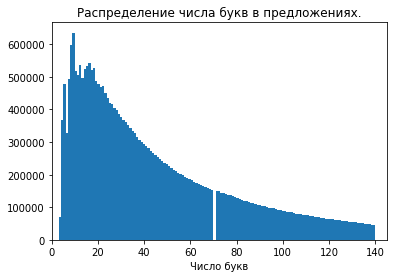

In [48]:
plt.hist(len_data, bins=140)
plt.title('Распределение числа букв в предложениях.')
plt.xlabel('Число букв')
plt.xlim((0, 145))
plt.show()

максимальное колличество слов  53


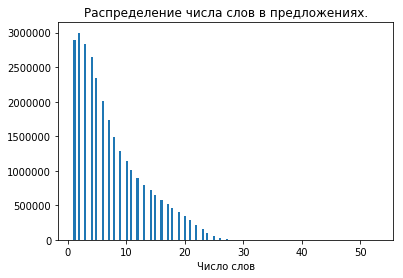

In [51]:
print('максимальное колличество слов ', np.array(cnt_word_data).max())
plt.hist(cnt_word_data, bins=140)
plt.title('Распределение числа слов в предложениях.')
plt.xlabel('Число слов')
#plt.xlim((0, 300))
plt.show()

максимальное колличество знаков препенания  42


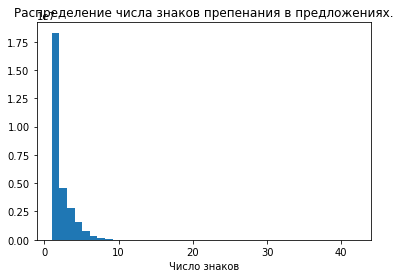

In [56]:
print('максимальное колличество знаков препенания ', np.array(cnt_punct_data).max())
plt.hist(cnt_punct_data, bins = 40)
plt.title('Распределение числа знаков препенания в предложениях.')
plt.xlabel('Число знаков')
plt.show()

In [57]:
#посчитаем частотность знаков пунктуации
# но не на всей выборке
len_data = 0
len_pun = {'.':0, ',':0, '!':0, '?':0, ':':0, ';':0}
punctuation = ['.', ',', '!', '?', ':', ';']
with open('flibusta_full_train.txt', 'r') as file:
    for _ in range(100000):
        line = file.readline()
        e_line = bpemb_ru.encode(line)
        len_data += len(e_line)
        for w in e_line:
            if w in punctuation:
                len_pun[w] += 1
for p in len_pun:
    print(f'частота знака {p} ', len_pun[p]/len_data)

частота знака .  0.058281337602438386
частота знака ,  0.03812767873091525
частота знака !  0.010106256111197727
частота знака ?  0.017691110769233947
частота знака :  0.0004093921687872802
частота знака ;  3.8719309784421205e-05


### модель

In [2]:
vocab_size = 3000 #размер словоря
emb_dim = 100 #размер эмбендингов
max_len = 200 # TODO посчитать максимальную длинну выборки
buffer_size = 5# размер буфера данных в батчах

In [28]:
bpemb_ru = BPEmb(lang='ru', vs=vocab_size , dim=emb_dim)

# bpemb_ru.encode_ids('.,!?:;')
#>>> [2922, 2921, 2978, 2985, 2947, 2963]
def load_emb_matrix(bpemb= bpemb_ru, dtype=np.float32):
    '''функция загрузки эмбендингов в модель'''
    
    return bpemb.emb.vectors.astype(dtype)

def parse_fn(line, bpemb = bpemb_ru):
    '''
        функция кодировки строки:
        line- строка
    '''
    sequence = np.array(bpemb.encode_ids(line) + [0]).astype(np.int32)
    punct_dic = {2922: 1, 2921: 2, 2978: 3, 2985: 4, 2947: 5, 2963: 6}
    feature = []
    label = []

    for i in range(len(sequence) - 1):
        if sequence[i] not in punct_dic:
            feature.append(sequence[i])
            if sequence[i + 1] in punct_dic:
                label.append(punct_dic[sequence[i + 1]])
            else:
                label.append(0)
                
    feature = np.array(feature).astype(np.int32)
    label = np.array(label).astype(np.int32)

    mask = ((label == 0)*0.6 + (label != 0)).astype(np.float32)
    
    return (feature, len(feature)), (label, len(label), mask)


def generator_fn(data_file_url):
    '''генератор чтения строк из файла и
        преобразования из в последовательности'''
    with open(data_file_url, 'r') as file:
        for row in file:
            yield parse_fn(row[:-1])


def input_fn(data_file_url, params, mode):
    '''функция подачи данных в модель,
        на вход получает адрес файла'''
    shapes = (([None], ()), ([None], (), [None]))
    types = ((tf.int32, tf.int32), (tf.int32, tf.int32, tf.float32))
    defaults = ((0, 0), (0, 0, 0.))

    dataset = tf.data.Dataset.from_generator(lambda : generator_fn(data_file_url),
                                             output_shapes=shapes, output_types=types)
    

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=params['train_size'], reshuffle_each_iteration=True)
        #dataset = dataset.repeat(params['num_epochs'])
        dataset = dataset.repeat()

    return dataset.padded_batch(params['batch_size'], shapes, defaults).prefetch(params['train_size'])    

def test_genarator_fn(data, bpemb=bpemb_ru):
    '''генератор преобразования массива стор
        в массив последовательностей'''
    for line in data:
        sequence = bpemb_ru.encode_ids(line)
        yield (np.array(sequence).astype(np.int32), len(sequence)), 0

def test_input_fn(data, params):
    '''функция подачи данных в модель для теста
        на вход получает массив строк'''
    shapes = ([None], ()), ()
    types = (tf.int32, tf.int32), tf.int32
    defaults = (0, 0), 0

    dataset = tf.data.Dataset.from_generator(lambda : test_genarator_fn(data),
                                             output_shapes=shapes, output_types=types)
    
    return dataset.padded_batch(params['batch_size'], shapes, defaults).prefetch(1)    

In [4]:
# модель
def model_fn(features, labels, mode, params):
    
    sequences, lengths = features
    current_butch_size = tf.shape(sequences)[0]

    # матрица эмбеддингов decoder-а
    embeddings = tf.Variable(initial_value = load_emb_matrix() ,trainable=False)
    
    # decoder
    cell  = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.GRUCell(num_units=params['lstm_hidden_dim']) 
                          for _ in range(params['num_layers'])])
    
    # (многослойная) LSTM
    encode_cell_fw  = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.GRUCell(num_units=params['lstm_hidden_dim']) 
                          for _ in range(params['num_layers'])])

    encode_cell_bw  = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.GRUCell(num_units=params['lstm_hidden_dim']) 
                          for _ in range(params['num_layers'])])
    
    encode_embedded = tf.nn.embedding_lookup(params=embeddings, ids=sequences)

    outputs, states = tf.nn.bidirectional_dynamic_rnn(   
                                                         encode_cell_fw,
                                                         encode_cell_bw,
                                                         encode_embedded, 
                                                         sequence_length=lengths, 
                                                         dtype=tf.float32
                                                     )
    # prepare output
    output = tf.concat(outputs, axis=-1)
    encoder_output = tf.layers.dense(output, params['lstm_hidden_dim'])
    
    #prepare state
    state_fw, state_bw = states
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_cells = []
    dense_cells = []
    for fw, bw in zip(state_fw, state_bw):
        state = tf.concat([fw, bw], axis=-1)
        dropout = tf.layers.dropout(inputs=state, 
                                    rate= params['dropout_rate'], 
                                    training=training)
        dropout_cells += [dropout]
        dense_cells += [tf.layers.dense(dropout, params['lstm_hidden_dim'])]
    encoder_state = tuple(dense_cells)
    
    # началное состояние
    #initial_state = tuple([tf.tile(tf.constant([[0]], tf.float32), [current_butch_size, params['lstm_hidden_dim']]) 
    #                       for _ in range(params['num_layers'])]) 
    attention = tf.contrib.seq2seq.BahdanauAttention(num_units=params['lstm_hidden_dim'], 
                                                     memory=encoder_output, 
                                                     memory_sequence_length=lengths)
    
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(cell, 
                                                       attention, 
                                                       attention_layer_size=params['lstm_hidden_dim'])
    
    decoder_initial_state = decoder_cell.zero_state(current_butch_size, 
                                                    tf.float32).clone(cell_state=encoder_state)
        

    sequences_embedded = tf.nn.embedding_lookup(params=embeddings, ids=sequences)
    
    #conv1d = tf.layers.conv1d(sequences_embedded, 128, 3)

    train_helper = tf.contrib.seq2seq.TrainingHelper(inputs=sequences_embedded, 
                                                      sequence_length=lengths)

    decoder = tf.contrib.seq2seq.BasicDecoder(cell=decoder_cell, 
                                              helper=train_helper, 
                                              initial_state=decoder_initial_state
                                             )

    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder=decoder,
                                                      maximum_iterations=params['max_iter'], 
                                                      impute_finished=True,
                                                      )

    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout = tf.layers.dropout(inputs=outputs.rnn_output, 
                                rate= params['dropout_rate'], 
                                training=training)
    
    dense1 = tf.layers.dense(dropout, params['lstm_hidden_dim'], activation=tf.math.tanh)

    dense2 = tf.layers.dense(dense1, params['output_vocab_size'])
    

    logits = dense2
    sample_id = tf.argmax(logits, 2)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'sequences': sequences,
            'prediction': sample_id,
            'lengths': lengths
        }

        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    else:
        target, target_lengths, mask = labels

        #mask = tf.sequence_mask(lengths, dtype=tf.float32)

        metrics = {
            'acc': tf.metrics.accuracy(target, sample_id, mask),
            #'f1_score' : tf.contrib.metrics.f1_score(target, sample_id, mask),
        }

        loss = tf.contrib.seq2seq.sequence_loss(logits=logits, 
                                                targets=target, 
                                                weights=mask, 
                                                average_across_timesteps=True, 
                                                average_across_batch=True)

        # в режиме eval возвращаем усреднённый лосс
        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

        # в режиме train ещё и обновляем обучаемые параметры
        elif mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.AdamOptimizer
            optimizer = optimizer(learning_rate=params['learning_rate'])
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())

            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    


In [5]:
params = {
    'vocab_size': vocab_size,
    'output_vocab_size': 7,
    'train_size': 256*buffer_size,
    'num_layers': 2,
    'embedding_dim': emb_dim,
    'dropout_rate': 0.2,
    'lstm_hidden_dim': 256,
    'max_iter': max_len,
    'batch_size': 256,
    'num_epochs': 1,
    'learning_rate': 1e-3
}

config = tf.estimator.RunConfig(model_dir='project1',
                                save_checkpoints_steps = 200,
                               save_checkpoints_secs = None)
model = tf.estimator.Estimator(model_fn=model_fn, params=params, config=config)

INFO:tensorflow:Using config: {'_model_dir': 'project1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 200, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff91682f6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
model.train(lambda: input_fn('flibusta_full_train.txt', params=params, mode='train'), steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into project1/model.ckpt.
INFO:tensorflow:loss = 1.9404808, step = 1
INFO:tensorflow:global_step/sec: 0.238312
INFO:tensorflow:loss = 0.81359076, step = 101 (419.619 sec)
INFO:tensorflow:Saving checkpoints for 200 into project1/model.ckpt.
INFO:tensorflow:global_step/sec: 0.245549
INFO:tensorflow:loss = 0.70945543, step = 201 (407.250 sec)
INFO:tensorflow:global_step/sec: 0.249256
INFO:tensorflow:loss = 0.57074714, step = 301 (401.195 sec)
INFO:tensorflow:Saving checkpoints for 400 into project1/model.ckpt.
INFO:tensorflow:global_step/sec: 0.253496
INFO:tensorflow:loss = 0.558376, step = 401 (394.483 sec)
INFO:tensorflow:global_step/sec: 0.256882
INFO:tensorflow:loss = 0.49290413, step = 501 (389.284 sec)
INFO:te

INFO:tensorflow:global_step/sec: 0.256627
INFO:tensorflow:loss = 0.30992445, step = 5801 (389.671 sec)
INFO:tensorflow:global_step/sec: 0.252491
INFO:tensorflow:loss = 0.32500422, step = 5901 (396.054 sec)
INFO:tensorflow:Saving checkpoints for 6000 into project1/model.ckpt.
INFO:tensorflow:global_step/sec: 0.26833
INFO:tensorflow:loss = 0.31633502, step = 6001 (372.676 sec)
INFO:tensorflow:global_step/sec: 0.25599
INFO:tensorflow:loss = 0.29338026, step = 6101 (390.641 sec)
INFO:tensorflow:Saving checkpoints for 6200 into project1/model.ckpt.
INFO:tensorflow:global_step/sec: 0.255154
INFO:tensorflow:loss = 0.26445055, step = 6201 (391.919 sec)
INFO:tensorflow:global_step/sec: 0.260649
INFO:tensorflow:loss = 0.261683, step = 6301 (383.657 sec)
INFO:tensorflow:Saving checkpoints for 6400 into project1/model.ckpt.
INFO:tensorflow:global_step/sec: 0.274724
INFO:tensorflow:loss = 0.32927114, step = 6401 (364.001 sec)
INFO:tensorflow:global_step/sec: 0.260949
INFO:tensorflow:loss = 0.312646

In [7]:
# обучение и валидация
eval_result = model.evaluate(lambda: input_fn('eval.txt', params=params, mode='eval'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-16-06:16:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-16-06:16:58
INFO:tensorflow:Saving dict for global step 10000: acc = 0.9203644, global_step = 10000, loss = 0.28058326
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: project1/model.ckpt-10000


In [39]:
# дешифровка 
def placement_punctuation(data, mode='from_list'):
    '''
        функция расстановки пунктуации (.,!,?:;)
        mode -  тип подоваемых данных:
                если 'from_list' то data должна быть массивом строк
                если 'from_file' то data должна быть путем до файла
        data -  либо строка, либо массив строк, в зависимости от mode
        
        -----------------------------------------------------------------
        пример:
        
        test_data = [
            'Он уже должен был прийти обратно Почему он не возвращается',
            'Я не знаю Аэтпио не видит ничего кроме мертвых камней'
        ]
        placement_punctuation(test_data)
        -----------------------------------------------------------------
        пример:
        
        placement_punctuation('test.txt', mode='from_file')
        -----------------------------------------------------------------
    '''
    d = {1:2922, 2:2921, 3:2978, 4:2985, 5:2947, 6:2963}
    if mode == 'from_file':
        prediction = model.predict(lambda: input_fn(data, params=params, mode='predicted'))
    else:
        prediction = model.predict(lambda: test_input_fn(data, params=params))
    for x in prediction:
        a = []
        for i in range(x['lengths']):
            a.append(x['sequences'][i])
            if x['prediction'][i] != 0:
                a.append(d[x['prediction'][i]])
        print(bpemb_ru.decode_ids(np.array(a)))


In [40]:
test_data = [
    'он уже должен был прийти обратно почему он не возвращается',
    'я не знаю аэтпио не видит ничего кроме мертвых камней'
]
placement_punctuation(test_data)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
он уже должен был прийти обратно. почему он не возвращается?
я не знаю. аэтпио не видит ничего, кроме мертвых камней.


In [42]:
placement_punctuation('test.txt', mode='from_file')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from project1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
он уже должен был прийти обратно. почему он не возвращается?
я не знаю. аэтпио не видит ничего, кроме мертвых камней.
и ютипа тоже, почему взгляд хранителей не может проникнуть глубже?
кто знает? ариман не смел. даже самому себе признаться, насколько сильно он встревожен.
я думал, ты сумеешь туда заглянуть. в конце концов, ты же корвид.
здесь это не поможет.
тебе легко говорить, но не всем же быть павонидами кое-кому приходится бороться с жарой собственными средствами.
с каких это пор ты овладел мастерством атенейцев?
мне этого не требуется. и так понятно, что вы оба встревожены. это очевидно.
